# <center> Trabajo Practico N1: Redes Convolucionales </center>
<div>
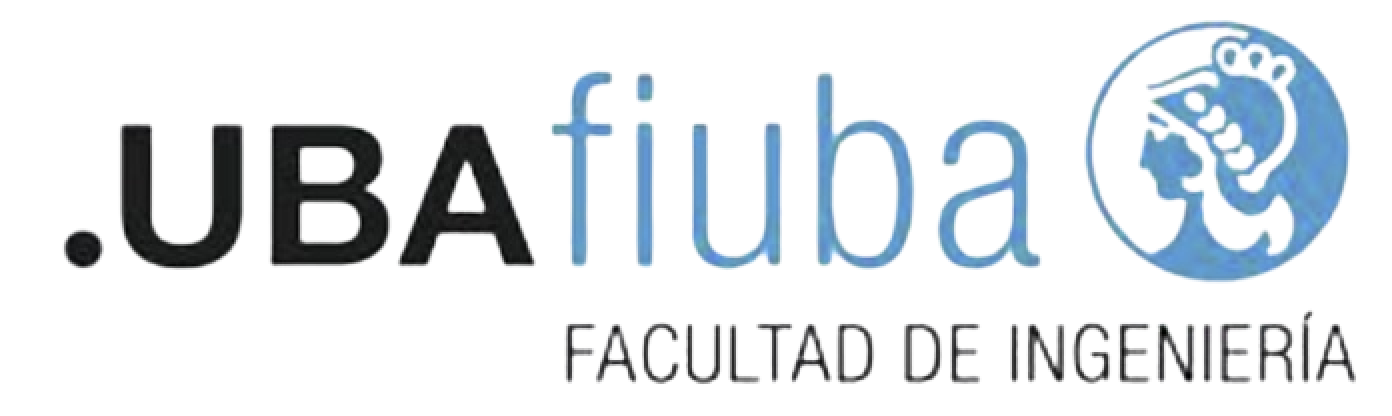
</div>

### <center>José Mornaghi y Lucas Argento</center>
 



> ##  Introducción


Con el objetivo de estudiar las redes neuronales convolucionales, sus aplicaciones y su diseño, se analizó un dataset público sobre imagenes MRI de pacientes con distintos grados de la enfermedad de Alzheimer. El objetivo del estudio fue clasificar las imagenes de entrada en 4 clases distintas, cada una indicando un distinto grado de avance de la enfermedad.

Para esto, se utilizó una red neuronal convolucional, para la cual se estudiaron diferentes decisiones de diseño y valores de sus hiperparamétros.

> ## Sobre los datos

El dataset público "Alzheimer MRI Preprocessed Dataset", disponible en Kaggle, contiene imágenes de 4 clases diferentes en tamaños de 128 x 128 pixeles.

Los datos fueron recolectados de diferentes paginas web, hospitales y repositoros públicos. Consisten en imagánes preprocesdad de resonancias magneticas MRI (por sus siglas en inglés Magnetic Resonance Imaging)

El dataset consiste en un total de 6400 imágenes, pertenecientes a una de las siguientes clases:
Clase - 1: Mild Demented (896 imágenes)
Clase - 2: Moderate Demented (64 imágenes)
Clase - 3: Non Demented (3200 imágenes)
Clase - 4: Very Mild Demented (2240 imágenes)

Elegimos este dataset en particular ya que consideramos que las CNNs tienen un potencial genuino para resolver este tipo de problemas en la vida real, agregando valor y mejorando la vida de las personas. 

Referencias:

* https://adni.loni.usc.edu/
* https://www.alzheimers.net/
* https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers
* https://ieeexplore.ieee.org/document/9521165
* https://catalog.data.gov/dataset/alzheimers-disease-and-healthy-aging-data
* https://www.nature.com/articles/s41598-020-79243-9
* https://cordis.europa.eu/article/id/429468-the-final-epad-dataset-is-now-available-on-the-alzheimer-s-disease-workbench

> ## Librerias a utilizar 

In [ ]:
%pip install torch torchvision

In [ ]:
%pip install pandas

In [ ]:
%pip install matplotlib

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from utils import train_model, compute_confusion_matrix

from plot_utils import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

> ## Visualizacion de las clases

Tenemos 4 clases de demencia asociadas a distintos niveles de Alzheimer. A continuacion mostramos ejemplos de MRI's para los distintos niveles mencionados:

In [7]:
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [10]:
#%pip install ipyplot
import ipyplot

images = ["Dataset/Mild_Demented/mild_10.jpg","Dataset/Moderate_Demented/moderate_10.jpg","Dataset/Non_Demented/non_10.jpg","Dataset/Very_Mild_Demented/verymild_10.jpg"]

ipyplot.plot_images(images, class_names, img_width=150)

> ## Carga de los datos y separación en sets de entrenamiento, validación y testeo

> _Split folders es un paquete que facilita el proceso de hacer un test-train-split con carpetas de imágenes_

In [21]:
#!pip install split-folders
import splitfolders
splitfolders.ratio('Dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1))

Copying files: 6400 files [00:02, 2993.52 files/s]


In [27]:
# Como se menciono antes, nuestro dataset contiene imagenes en 128x128
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Transformamos a tensores para poder procesar las imagenes con PyTorch
transform = transforms.ToTensor()

# Transformaciones y loadding
train_data = datasets.ImageFolder(root='output/train',transform=transform)
test_data = datasets.ImageFolder(root='output/test',transform=transform)
val_data = datasets.ImageFolder(root='output/val',transform=transform)

> ## Arquitectura Propuesta

Para el estudio de las CNNs, decidimos partir de la arquitectura original de la Red Neuronal **LeNet** (1998), la cual luego modificaremos para estudiar los efectos de las distintas decisiones de diseño. 
A continuacion, se observa un esquema de la arquitectura original, compuesta por dos capas convolucionales y 3 capas FullyConnected de Perceptrones Multicapa. Si bien la red original usaba funciones de activacion de tangenge hiperbólica, en nuestro caso se utilizaron funciones ReLu.

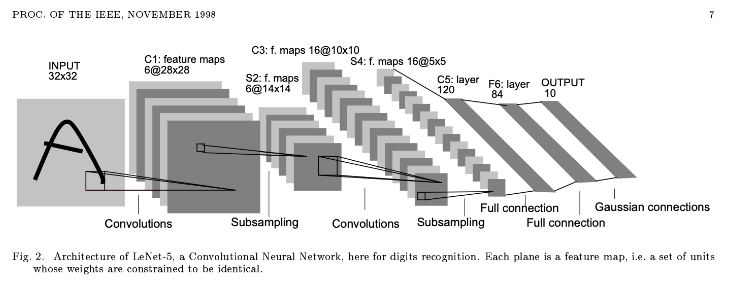

In [102]:
class LeNet5(nn.Module):

    def __init__(self, n_canales_rgb, n_clases, cantidad_filtros_conv, tamaño_filtro_conv, 
                 tamaño_kernel_pooling, stride, padding):
        super().__init__()
        # cantidad de canales y clases, a definir por el diseñador
        self.n_canales_rgb = n_canales_rgb
        self.n_clases = n_clases
        self.tamaño_kernel_pooling = tamaño_kernel_pooling
        # Le net tiene dos capas convolucionales
        self.conv1 = nn.Conv2d(self.n_canales_rgb, cantidad_filtros_conv, kernel_size=tamaño_filtro_conv)
        
        outputconv1 = math.ceil(((128 - tamaño_filtro_conv)/stride))
        print("imagenes de salida post convolucion1:", outputconv1, "x", outputconv1)
        outputconv1 = math.ceil(outputconv1 / tamaño_kernel_pooling)
        print("imagenes de salida post pooling1:", outputconv1, "x", outputconv1)
        
        self.conv2 = nn.Conv2d(cantidad_filtros_conv, 16, kernel_size=tamaño_filtro_conv)
        
        outputconv2 = math.ceil((outputconv1 - tamaño_filtro_conv /stride))
        print("imagenes de salida post convolucion2:", outputconv2, "x", outputconv2)
        outputconv2 = math.ceil(outputconv2 / tamaño_kernel_pooling)
        print("imagenes de salida post pooling2:", outputconv2, "x", outputconv2)

        # size del vector de parametros luego de las capas convolucionales
        cantidad_parametros = math.ceil(16 * outputconv2 * outputconv2)
        # y tres capas de MLPs
        
        # primer MLP
        inputfc1 = math.ceil(cantidad_parametros)
        print("parametros de entrada del primer perceptron:", inputfc1)
        outputfc1 = math.ceil((3/4)*inputfc1)
        print("parametros de salida del primer perceptron:", outputfc1)
        
        self.fc1 = torch.nn.Linear(inputfc1, outputfc1)
        # segundo MLP
        inputfc2 = outputfc1
        print("parametros de entrada del segundo perceptron:", inputfc2)
        outputfc2 = math.ceil(inputfc2*(1/2))
        print("parametros de salida del segundo perceptron:", outputfc2)
        self.fc2 = torch.nn.Linear(inputfc2, outputfc2)
        # tercer MLP. salida con cantidad de clases
        inputfc3 = outputfc2
        print("parametros de entrada del tercer perceptron:", inputfc3)
        self.fc3 = torch.nn.Linear(inputfc3, self.n_clases)

    def forward(self, x):
        # capa convolucional
        x = self.conv1(x)
        # al resultado de la convolucion, le aplica una ReLu
        x = F.relu(x)
        # y luego un pooling
        x = F.max_pool2d(x, (self.tamaño_kernel_pooling, self.tamaño_kernel_pooling))
        
        # Segunda capa convolucional
        x = self.conv2(x)
        # aplica relu
        x = F.relu(x)
        # pooling 
        x = F.max_pool2d(x, (self.tamaño_kernel_pooling, self.tamaño_kernel_pooling))
        
        # flatten de las imagenes para pasarlo a MLPs
        x = torch.flatten(x, 1)
        # MLPs con relus
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

> _Puesto que variaremos los hiperparametros de nuestra red en reiteradas ocaciones, vamos a modularizar el proceso de creación y entrenamiento del modelo a través de una función_

In [86]:
def crear_modelo(cantidad_filtros_conv, tamaño_filtro_conv, tamaño_kernel_pooling, stride, padding):
    # Instanciamos la clase del modelo:
    model = LeNet5(3, 4, cantidad_filtros_conv, tamaño_filtro_conv, tamaño_kernel_pooling, stride, padding)
    # CUDA / CPU
    model = model.to('cpu')
    return model

In [87]:
def entrenar_modelo(model, optimizer, epocas, batch_size, train_data, val_data, test_data):
    # Cargamos data en PyTorch
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               num_workers=0)

    valid_loader = torch.utils.data.DataLoader(val_data,
                                               batch_size=batch_size,
                                               num_workers=0)

    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    # Entrenamiento del modelo
    minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
        model=model,
        num_epochs=NUM_EPOCAS,
        train_loader=train_loader,
        valid_loader=valid_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        device='cpu',
        log_interval_batch=5)
    # Devuelvo listas para controlar el desempeño del entrenamiento
    return minibatch_loss_list, train_acc_list, valid_acc_list, train_loader

> _La optimización de la red se realizará con el algoritmo del descenso del gradiente estocástico_

> ## Primer modelo y entrenamiento

In [111]:
model_1= crear_modelo(6, 3, 2, 1, 0)

imagenes de salida post convolucion1: 125 x 125
imagenes de salida post pooling1: 63 x 63
imagenes de salida post convolucion2: 60 x 60
imagenes de salida post pooling2: 30 x 30
parametros de entrada del primer perceptron: 14400
parametros de salida del primer perceptron: 10800
parametros de entrada del segundo perceptron: 10800
parametros de salida del segundo perceptron: 5400
parametros de entrada del tercer perceptron: 5400


In [112]:
#optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.1)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7407771/#:~:text=The%20Adam%20optimizer%20had%20the,ability%20in%20classification%20and%20segmentation

In [113]:
NUM_EPOCAS = 10
valid_size = 0.2
batch_size = 64

In [ ]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_1, 
                                                                      optimizer, 
                                                                      NUM_EPOCAS, 
                                                                      batch_size, 
                                                                      train_data, 
                                                                      val_data, 
                                                                      test_data)

salida prop adelante tensor([[ 1.5779e-03, -1.3623e-02,  2.4847e-03, -1.2999e-03],
        [ 8.1655e-04, -1.4822e-02, -4.9599e-04, -2.6178e-03],
        [ 4.9672e-06, -1.3135e-02,  2.6462e-03, -1.8371e-03],
        [ 1.1167e-04, -2.0329e-02,  2.9730e-03, -7.6407e-04],
        [-4.9643e-04, -1.3062e-02, -1.7708e-03, -3.0658e-03],
        [-5.9906e-05, -1.2184e-02,  1.5140e-03,  9.7944e-04],
        [-8.9661e-05, -1.5179e-02, -1.3887e-03, -1.4878e-03],
        [-1.0360e-03, -1.4318e-02,  2.6163e-03, -4.7997e-03],
        [ 1.9894e-03, -1.4418e-02, -7.3321e-04, -2.8607e-03],
        [-3.3044e-04, -1.6593e-02,  2.5163e-03, -1.1735e-03],
        [ 7.9331e-04, -1.5657e-02,  9.5900e-04, -1.0161e-03],
        [-2.7305e-04, -1.5308e-02,  3.5330e-03, -5.7445e-04],
        [ 1.1418e-03, -1.4470e-02, -8.5436e-04, -4.0433e-03],
        [ 1.2095e-04, -1.6226e-02, -9.5363e-04, -2.4828e-03],
        [ 7.9481e-04, -1.2071e-02, -2.0620e-03, -3.3410e-03],
        [-9.1482e-04, -1.6163e-02,  1.2103e-05, -

salida prop adelante tensor([[ 1.0689e+09, -1.0431e+09, -1.0426e+09, -1.0425e+09],
        [ 8.6292e+08, -8.4212e+08, -8.4173e+08, -8.4162e+08],
        [ 8.4737e+08, -8.2694e+08, -8.2656e+08, -8.2645e+08],
        [ 1.1037e+09, -1.0771e+09, -1.0766e+09, -1.0765e+09],
        [ 1.1334e+09, -1.1060e+09, -1.1055e+09, -1.1054e+09],
        [ 1.0667e+09, -1.0410e+09, -1.0405e+09, -1.0404e+09],
        [ 1.0753e+09, -1.0493e+09, -1.0489e+09, -1.0487e+09],
        [ 1.0677e+09, -1.0420e+09, -1.0415e+09, -1.0414e+09],
        [ 9.7079e+08, -9.4739e+08, -9.4695e+08, -9.4683e+08],
        [ 1.0163e+09, -9.9184e+08, -9.9138e+08, -9.9125e+08],
        [ 1.1131e+09, -1.0862e+09, -1.0857e+09, -1.0856e+09],
        [ 1.1178e+09, -1.0908e+09, -1.0903e+09, -1.0902e+09],
        [ 1.0637e+09, -1.0381e+09, -1.0376e+09, -1.0375e+09],
        [ 1.0832e+09, -1.0571e+09, -1.0566e+09, -1.0565e+09],
        [ 1.0469e+09, -1.0217e+09, -1.0212e+09, -1.0211e+09],
        [ 8.8240e+08, -8.6113e+08, -8.6073e+08, -

salida prop adelante tensor([[ 9.2646e+09, -9.1188e+09, -9.1161e+09, -9.1153e+09],
        [ 8.4587e+09, -8.3256e+09, -8.3231e+09, -8.3224e+09],
        [ 8.2473e+09, -8.1175e+09, -8.1151e+09, -8.1144e+09],
        [ 9.1823e+09, -9.0379e+09, -9.0351e+09, -9.0344e+09],
        [ 8.8768e+09, -8.7372e+09, -8.7345e+09, -8.7338e+09],
        [ 9.3108e+09, -9.1643e+09, -9.1615e+09, -9.1608e+09],
        [ 7.3575e+09, -7.2417e+09, -7.2396e+09, -7.2390e+09],
        [ 8.9530e+09, -8.8121e+09, -8.8095e+09, -8.8087e+09],
        [ 8.9575e+09, -8.8165e+09, -8.8139e+09, -8.8131e+09],
        [ 9.2030e+09, -9.0582e+09, -9.0555e+09, -9.0547e+09],
        [ 9.2410e+09, -9.0956e+09, -9.0929e+09, -9.0921e+09],
        [ 9.2586e+09, -9.1130e+09, -9.1102e+09, -9.1095e+09],
        [ 9.0805e+09, -8.9376e+09, -8.9349e+09, -8.9342e+09],
        [ 8.1373e+09, -8.0093e+09, -8.0069e+09, -8.0062e+09],
        [ 9.0942e+09, -8.9511e+09, -8.9484e+09, -8.9476e+09],
        [ 9.4852e+09, -9.3360e+09, -9.3332e+09, -

Epoca: 001/010 | Batch 0005/0080 | Loss: 0.0000
salida prop adelante tensor([[ 2.7625e+10, -2.7275e+10, -2.7268e+10, -2.7266e+10],
        [ 2.1797e+10, -2.1521e+10, -2.1516e+10, -2.1514e+10],
        [ 2.6865e+10, -2.6525e+10, -2.6519e+10, -2.6517e+10],
        [ 2.6424e+10, -2.6089e+10, -2.6083e+10, -2.6081e+10],
        [ 2.7305e+10, -2.6959e+10, -2.6953e+10, -2.6951e+10],
        [ 2.6941e+10, -2.6600e+10, -2.6593e+10, -2.6592e+10],
        [ 2.7949e+10, -2.7594e+10, -2.7588e+10, -2.7586e+10],
        [ 2.7555e+10, -2.7205e+10, -2.7199e+10, -2.7197e+10],
        [ 2.5761e+10, -2.5434e+10, -2.5428e+10, -2.5427e+10],
        [ 2.8713e+10, -2.8349e+10, -2.8342e+10, -2.8340e+10],
        [ 2.5775e+10, -2.5448e+10, -2.5442e+10, -2.5440e+10],
        [ 2.6957e+10, -2.6615e+10, -2.6609e+10, -2.6607e+10],
        [ 2.7877e+10, -2.7523e+10, -2.7517e+10, -2.7515e+10],
        [ 2.8546e+10, -2.8184e+10, -2.8177e+10, -2.8175e+10],
        [ 2.2619e+10, -2.2332e+10, -2.2327e+10, -2.2325e+10],
 

salida prop adelante tensor([[ 5.6952e+10, -5.6322e+10, -5.6310e+10, -5.6307e+10],
        [ 5.3425e+10, -5.2833e+10, -5.2822e+10, -5.2819e+10],
        [ 5.6013e+10, -5.5393e+10, -5.5381e+10, -5.5378e+10],
        [ 4.7757e+10, -4.7229e+10, -4.7219e+10, -4.7216e+10],
        [ 5.7283e+10, -5.6649e+10, -5.6637e+10, -5.6634e+10],
        [ 5.6667e+10, -5.6040e+10, -5.6028e+10, -5.6025e+10],
        [ 5.2098e+10, -5.1522e+10, -5.1511e+10, -5.1508e+10],
        [ 5.2532e+10, -5.1951e+10, -5.1940e+10, -5.1937e+10],
        [ 5.6122e+10, -5.5501e+10, -5.5490e+10, -5.5486e+10],
        [ 4.7987e+10, -4.7455e+10, -4.7446e+10, -4.7443e+10],
        [ 5.0245e+10, -4.9689e+10, -4.9678e+10, -4.9676e+10],
        [ 5.6261e+10, -5.5638e+10, -5.5626e+10, -5.5623e+10],
        [ 5.6820e+10, -5.6191e+10, -5.6180e+10, -5.6176e+10],
        [ 5.3975e+10, -5.3377e+10, -5.3366e+10, -5.3363e+10],
        [ 4.7183e+10, -4.6661e+10, -4.6651e+10, -4.6649e+10],
        [ 5.1836e+10, -5.1263e+10, -5.1252e+10, -

salida prop adelante tensor([[ 9.3008e+10, -9.2070e+10, -9.2053e+10, -9.2048e+10],
        [ 8.2057e+10, -8.1230e+10, -8.1215e+10, -8.1210e+10],
        [ 9.1526e+10, -9.0603e+10, -9.0586e+10, -9.0581e+10],
        [ 9.0856e+10, -8.9940e+10, -8.9923e+10, -8.9919e+10],
        [ 8.6567e+10, -8.5695e+10, -8.5679e+10, -8.5674e+10],
        [ 8.4829e+10, -8.3974e+10, -8.3958e+10, -8.3954e+10],
        [ 9.0229e+10, -8.9319e+10, -8.9303e+10, -8.9298e+10],
        [ 8.8266e+10, -8.7376e+10, -8.7360e+10, -8.7355e+10],
        [ 7.9711e+10, -7.8907e+10, -7.8892e+10, -7.8888e+10],
        [ 8.7855e+10, -8.6969e+10, -8.6953e+10, -8.6949e+10],
        [ 8.3888e+10, -8.3043e+10, -8.3027e+10, -8.3023e+10],
        [ 6.6846e+10, -6.6172e+10, -6.6159e+10, -6.6156e+10],
        [ 8.5005e+10, -8.4148e+10, -8.4133e+10, -8.4128e+10],
        [ 9.2149e+10, -9.1220e+10, -9.1203e+10, -9.1199e+10],
        [ 8.8837e+10, -8.7941e+10, -8.7925e+10, -8.7920e+10],
        [ 8.7996e+10, -8.7108e+10, -8.7092e+10, -

salida prop adelante tensor([[ 5.7068e+10, -5.6444e+10, -5.6447e+10, -6.5802e+10],
        [ 6.4629e+10, -6.3922e+10, -6.3925e+10, -7.4520e+10],
        [ 6.3690e+10, -6.2993e+10, -6.2997e+10, -7.3438e+10],
        [ 5.9491e+10, -5.8840e+10, -5.8843e+10, -6.8596e+10],
        [ 6.2706e+10, -6.2020e+10, -6.2023e+10, -7.2303e+10],
        [ 6.5846e+10, -6.5126e+10, -6.5129e+10, -7.5924e+10],
        [ 6.0755e+10, -6.0090e+10, -6.0093e+10, -7.0053e+10],
        [ 6.0850e+10, -6.0184e+10, -6.0187e+10, -7.0163e+10],
        [ 6.3218e+10, -6.2527e+10, -6.2530e+10, -7.2894e+10],
        [ 5.3147e+10, -5.2566e+10, -5.2568e+10, -6.1281e+10],
        [ 5.7252e+10, -5.6626e+10, -5.6629e+10, -6.6014e+10],
        [ 5.5226e+10, -5.4621e+10, -5.4624e+10, -6.3677e+10],
        [ 6.1597e+10, -6.0923e+10, -6.0926e+10, -7.1024e+10],
        [ 5.4504e+10, -5.3908e+10, -5.3911e+10, -6.2846e+10],
        [ 6.4454e+10, -6.3749e+10, -6.3752e+10, -7.4319e+10],
        [ 6.3274e+10, -6.2581e+10, -6.2585e+10, -

salida prop adelante tensor([[ 5.0762e+09, -6.1475e+09, -5.4760e+09, -1.0282e+10],
        [ 4.9704e+09, -6.0196e+09, -5.3620e+09, -1.0068e+10],
        [ 4.6468e+09, -5.6281e+09, -5.0130e+09, -9.4150e+09],
        [ 4.9632e+09, -6.0111e+09, -5.3542e+09, -1.0055e+10],
        [ 4.9585e+09, -6.0031e+09, -5.3486e+09, -1.0034e+10],
        [ 4.6351e+09, -5.6140e+09, -5.0004e+09, -9.3919e+09],
        [ 4.0849e+09, -4.9478e+09, -4.4069e+09, -8.2782e+09],
        [ 4.0910e+09, -4.9551e+09, -4.4134e+09, -8.2902e+09],
        [ 4.6294e+09, -5.6070e+09, -4.9942e+09, -9.3801e+09],
        [ 4.3115e+09, -5.2221e+09, -4.6513e+09, -8.7366e+09],
        [ 4.3849e+09, -5.3107e+09, -4.7304e+09, -8.8836e+09],
        [ 4.6433e+09, -5.6238e+09, -5.0092e+09, -9.4076e+09],
        [ 4.7680e+09, -5.7730e+09, -5.1433e+09, -9.6511e+09],
        [ 4.6387e+09, -5.6186e+09, -5.0043e+09, -9.4003e+09],
        [ 4.8014e+09, -5.8147e+09, -5.1796e+09, -9.7253e+09],
        [ 4.4529e+09, -5.3930e+09, -4.8037e+09, -

Epoca: 001/010 | Batch 0015/0080 | Loss: 0.0000
salida prop adelante tensor([[-2.2411e+08,  1.4081e+08,  2.2086e+08, -4.2835e+05],
        [-2.1318e+08,  1.3394e+08,  2.1008e+08, -4.0716e+05],
        [-2.0022e+08,  1.2580e+08,  1.9732e+08, -3.8232e+05],
        [-2.1715e+08,  1.3644e+08,  2.1400e+08, -4.1471e+05],
        [-2.2805e+08,  1.4328e+08,  2.2474e+08, -4.3408e+05],
        [-1.8565e+08,  1.1664e+08,  1.8295e+08, -3.4923e+05],
        [-2.1986e+08,  1.3814e+08,  2.1667e+08, -4.1323e+05],
        [-1.7326e+08,  1.0886e+08,  1.7075e+08, -3.3181e+05],
        [-2.0386e+08,  1.2808e+08,  2.0090e+08, -3.8955e+05],
        [-2.2112e+08,  1.3893e+08,  2.1792e+08, -4.2374e+05],
        [-2.2019e+08,  1.3835e+08,  2.1700e+08, -4.1966e+05],
        [-2.1005e+08,  1.3197e+08,  2.0700e+08, -4.0179e+05],
        [-1.9501e+08,  1.2253e+08,  1.9218e+08, -3.7350e+05],
        [-2.3215e+08,  1.4586e+08,  2.2878e+08, -4.4180e+05],
        [-2.0250e+08,  1.2723e+08,  1.9957e+08, -3.8600e+05],
 

salida prop adelante tensor([[-1.5156e+08,  8.6261e+07,  1.4998e+08, -1.8864e+05],
        [-1.4658e+08,  8.3427e+07,  1.4506e+08, -1.8231e+05],
        [-1.3409e+08,  7.6319e+07,  1.3270e+08, -1.6671e+05],
        [-1.5311e+08,  8.7140e+07,  1.5151e+08, -1.9058e+05],
        [-1.3867e+08,  7.8923e+07,  1.3723e+08, -1.7245e+05],
        [-1.3569e+08,  7.7229e+07,  1.3428e+08, -1.6874e+05],
        [-1.5268e+08,  8.6899e+07,  1.5109e+08, -1.9011e+05],
        [-1.4200e+08,  8.0819e+07,  1.4052e+08, -1.7655e+05],
        [-1.5528e+08,  8.8375e+07,  1.5366e+08, -1.9323e+05],
        [-1.3669e+08,  7.7799e+07,  1.3527e+08, -1.6943e+05],
        [-1.4476e+08,  8.2391e+07,  1.4326e+08, -1.7996e+05],
        [-1.4962e+08,  8.5156e+07,  1.4806e+08, -1.8618e+05],
        [-1.2781e+08,  7.2745e+07,  1.2648e+08, -1.5867e+05],
        [-1.3677e+08,  7.7844e+07,  1.3535e+08, -1.7007e+05],
        [-1.5458e+08,  8.7977e+07,  1.5297e+08, -1.9245e+05],
        [-1.5275e+08,  8.6937e+07,  1.5116e+08, -

salida prop adelante tensor([[-3.6408e+07,  1.9673e+07,  3.6100e+07, -3.3170e+04],
        [-3.7062e+07,  2.0026e+07,  3.6749e+07, -3.3719e+04],
        [-3.6244e+07,  1.9584e+07,  3.5937e+07, -3.3001e+04],
        [-3.6418e+07,  1.9678e+07,  3.6110e+07, -3.3146e+04],
        [-3.7793e+07,  2.0421e+07,  3.7474e+07, -3.4434e+04],
        [-3.5227e+07,  1.9034e+07,  3.4929e+07, -3.2073e+04],
        [-3.6404e+07,  1.9671e+07,  3.6097e+07, -3.3133e+04],
        [-3.6155e+07,  1.9536e+07,  3.5850e+07, -3.2946e+04],
        [-3.6693e+07,  1.9827e+07,  3.6383e+07, -3.3455e+04],
        [-3.6817e+07,  1.9894e+07,  3.6506e+07, -3.3576e+04],
        [-3.6554e+07,  1.9751e+07,  3.6245e+07, -3.3308e+04],
        [-3.5841e+07,  1.9366e+07,  3.5538e+07, -3.2659e+04],
        [-3.6149e+07,  1.9533e+07,  3.5843e+07, -3.2960e+04],
        [-3.6617e+07,  1.9786e+07,  3.6307e+07, -3.3394e+04],
        [-3.6362e+07,  1.9648e+07,  3.6055e+07, -3.3143e+04],
        [-3.5311e+07,  1.9080e+07,  3.5012e+07, -

salida prop adelante tensor([[-4.5494e+07,  2.3820e+07,  4.5161e+07, -3.4619e+04],
        [-4.6331e+07,  2.4259e+07,  4.5992e+07, -3.5268e+04],
        [-4.6830e+07,  2.4520e+07,  4.6487e+07, -3.5632e+04],
        [-4.6061e+07,  2.4118e+07,  4.5724e+07, -3.5070e+04],
        [-4.6203e+07,  2.4192e+07,  4.5865e+07, -3.5175e+04],
        [-4.6298e+07,  2.4241e+07,  4.5959e+07, -3.5233e+04],
        [-4.5859e+07,  2.4012e+07,  4.5524e+07, -3.4919e+04],
        [-4.4142e+07,  2.3113e+07,  4.3819e+07, -3.3590e+04],
        [-4.5528e+07,  2.3838e+07,  4.5194e+07, -3.4647e+04],
        [-4.5735e+07,  2.3947e+07,  4.5401e+07, -3.4799e+04],
        [-4.6413e+07,  2.4302e+07,  4.6073e+07, -3.5310e+04],
        [-4.6461e+07,  2.4327e+07,  4.6121e+07, -3.5348e+04],
        [-4.6228e+07,  2.4205e+07,  4.5890e+07, -3.5176e+04],
        [-4.6268e+07,  2.4226e+07,  4.5929e+07, -3.5191e+04],
        [-4.6759e+07,  2.4483e+07,  4.6416e+07, -3.5559e+04],
        [-4.5830e+07,  2.3997e+07,  4.5495e+07, -

salida prop adelante tensor([[-6.5775e+07,  3.3729e+07,  6.5341e+07, -4.3966e+04],
        [-6.6088e+07,  3.3889e+07,  6.5652e+07, -4.4174e+04],
        [-6.6308e+07,  3.4002e+07,  6.5870e+07, -4.4321e+04],
        [-6.6659e+07,  3.4182e+07,  6.6219e+07, -4.4556e+04],
        [-6.6112e+07,  3.3901e+07,  6.5675e+07, -4.4190e+04],
        [-6.5784e+07,  3.3734e+07,  6.5350e+07, -4.3973e+04],
        [-6.6375e+07,  3.4036e+07,  6.5937e+07, -4.4367e+04],
        [-6.5977e+07,  3.3833e+07,  6.5542e+07, -4.4100e+04],
        [-6.5979e+07,  3.3834e+07,  6.5544e+07, -4.4103e+04],
        [-6.5697e+07,  3.3689e+07,  6.5263e+07, -4.3913e+04],
        [-6.6299e+07,  3.3997e+07,  6.5861e+07, -4.4315e+04],
        [-6.5413e+07,  3.3543e+07,  6.4982e+07, -4.3725e+04],
        [-6.6131e+07,  3.3912e+07,  6.5695e+07, -4.4203e+04],
        [-6.5565e+07,  3.3621e+07,  6.5132e+07, -4.3825e+04],
        [-6.5869e+07,  3.3777e+07,  6.5434e+07, -4.4029e+04],
        [-6.5899e+07,  3.3792e+07,  6.5464e+07, -

Epoca: 001/010 | Batch 0025/0080 | Loss: 0.0000
salida prop adelante tensor([[-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
        [-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
        [-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
        [-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
        [-9.1574e+07,  4.6277e+07,  9.1015e+07, -5.5579e+04],
        [-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
        [-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
        [-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
        [-9.1564e+07,  4.6272e+07,  9.1006e+07, -5.5574e+04],
        [-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
        [-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
        [-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
        [-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
        [-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
        [-9.1553e+07,  4.6266e+07,  9.0994e+07, -5.5567e+04],
 

salida prop adelante tensor([[-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -6.7134e+04],
        [-1.1934e+08,  5.9668e+07,  1.1865e+08, -

salida prop adelante tensor([[-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -7.7866e+04],
        [-1.4684e+08,  7.2834e+07,  1.4604e+08, -

salida prop adelante tensor([[-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -8.7600e+04],
        [-1.7306e+08,  8.5317e+07,  1.7215e+08, -

salida prop adelante tensor([[-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -9.6273e+04],
        [-1.9737e+08,  9.6835e+07,  1.9635e+08, -

Epoca: 001/010 | Batch 0035/0080 | Loss: 0.0000
salida prop adelante tensor([[-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
        [-2.1939e+08,  1.0724e+08,  2.1830e+08, -1.0389e+05],
 

salida prop adelante tensor([[-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -1.1051e+05],
        [-2.3901e+08,  1.1648e+08,  2.3784e+08, -

salida prop adelante tensor([[-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -1.1620e+05],
        [-2.5624e+08,  1.2458e+08,  2.5500e+08, -

salida prop adelante tensor([[-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -1.2106e+05],
        [-2.7120e+08,  1.3160e+08,  2.6991e+08, -

salida prop adelante tensor([[-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -1.2518e+05],
        [-2.8407e+08,  1.3763e+08,  2.8273e+08, -

Epoca: 001/010 | Batch 0045/0080 | Loss: 0.0000
salida prop adelante tensor([[-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
        [-2.9506e+08,  1.4277e+08,  2.9368e+08, -1.2866e+05],
 

salida prop adelante tensor([[-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -1.3159e+05],
        [-3.0438e+08,  1.4713e+08,  3.0296e+08, -

salida prop adelante tensor([[-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -1.3404e+05],
        [-3.1224e+08,  1.5081e+08,  3.1080e+08, -

salida prop adelante tensor([[-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  2.0438e+07],
        [-3.0604e+08,  1.4470e+08,  2.9959e+08,  

salida prop adelante tensor([[-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  5.6717e+07],
        [-1.8282e+08,  8.0971e+07,  1.5296e+08,  

Epoca: 001/010 | Batch 0055/0080 | Loss: 0.0000
salida prop adelante tensor([[-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
        [-6.1244e+07,  1.9286e+07,  1.6405e+04,  7.3525e+07],
 

salida prop adelante tensor([[ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -4264809.5000,  -8629292.0000, -68839072.0000,  66612916.0000],
        [ -426480

salida prop adelante tensor([[ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101216.],
        [ 14785448., -15652486., -79037112.,  49101

salida prop adelante tensor([[  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  6612313.5000,  -6619953.5000, -37739720.0000,  24570000.0000],
        [  661231

salida prop adelante tensor([[  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  2219147.5000,  -2221705.0000, -13634769.0000,   9216322.0000],
        [  221914

salida prop adelante tensor([[  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203715.1406],
        [  45149.2500,  -45201.4766, -293587.6250,  203

salida prop adelante tensor([[  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223605.1094],
        [  46522.8906,  -46576.5781, -316191.7188,  223

Epoca: 001/010 | Batch 0070/0080 | Loss: 0.0000
salida prop adelante tensor([[  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
        [  47562.7109,  -47617.5078, -334734.2812,  240095.1875],
       

salida prop adelante tensor([[  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261733.5469],
        [  49881.5078,  -49938.8672, -360971.6875,  261

salida prop adelante tensor([[  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284470.9062],
        [  52572.5469,  -52632.9180, -389049.7500,  284

salida prop adelante tensor([[  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304094.8125],
        [  54835.3867,  -54898.2812, -413163.8750,  304

salida prop adelante tensor([[  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320860.6875],
        [  56728.7227,  -56793.7188, -433686.1562,  320

Epoca: 002/010 | Batch 0000/0080 | Loss: 270711.4688
salida prop adelante tensor([[  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
        [  79256.3750,  -54167.2812, -417631.4688,  308456.7500],
  

salida prop adelante tensor([[ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232608.2031],
        [ 124324.4453,  -43079.1094, -327872.9375,  232

salida prop adelante tensor([[ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119942.5078],
        [ 143461.8438,  -32177.2520, -210885.7812,  119

salida prop adelante tensor([[ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5714.4170],
        [ 120459.5000,  -24672.5703, -100546.4531,    5

salida prop adelante tensor([[115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -38571.1641],
        [115673.3516, -19903.0566, -62298.6094, -

Epoca: 002/010 | Batch 0010/0080 | Loss: 0.0000
salida prop adelante tensor([[122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
        [122665.4844, -16884.7168, -52390.5078, -53504.5781],
 

salida prop adelante tensor([[ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -46588.1328],
        [ 72125.0078,   1644.3679, -17670.0703, -

salida prop adelante tensor([[ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -30597.9258],
        [ 21268.6465,   8123.9829,   8535.8623, -

salida prop adelante tensor([[  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -12824.6016],
        [  1039.5864,   7106.4229,  11130.5176, -

salida prop adelante tensor([[-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.5757],
        [-6253.5312,  4963.5361,  9163.7480, -3200.

salida prop adelante tensor([[-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.3303],
        [-4720.6602,  2342.3057,  4701.2163,    -5.

salida prop adelante tensor([[-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
        [-165.5878,  102.1984,  207.1554,  -47.2093],
       

salida prop adelante tensor([[-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
        [-211.5878,  105.6372,  222.2656,  -13.8446],
       

Epoca: 002/010 | Batch 0030/0080 | Loss: 0.0000
salida prop adelante tensor([[-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242.9554,  113.7282,  243.0271,   -2.1102],
        [-242

salida prop adelante tensor([[-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
        [-267.1658,  123.9698,  267.2306,   -2.2119],
       

salida prop adelante tensor([[-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
        [-285.7992,  131.8219,  285.8585,   -2.2882],
       

salida prop adelante tensor([[-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
        [-299.9708,  137.7779,  300.0258,   -2.3454],
       

salida prop adelante tensor([[-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
        [-310.6592,  142.2616,  310.7109,   -2.3880],
       

Epoca: 002/010 | Batch 0045/0080 | Loss: 0.0000
salida prop adelante tensor([[-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318.6723,  145.6184,  318.7214,   -2.4196],
        [-318

salida prop adelante tensor([[-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
        [-324.6534,  148.1217,  324.7007,   -2.4431],
       

salida prop adelante tensor([[-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
        [-328.4365,  149.7149,  327.9843,   15.5178],
       

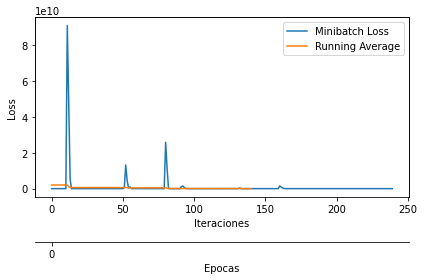

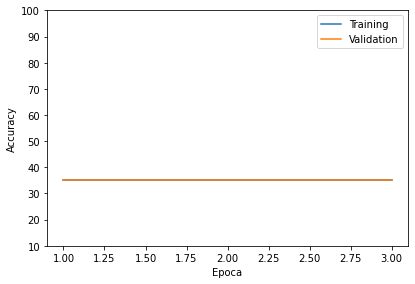

In [110]:
# Plot function de utils
plot_training_loss(minibatch_loss_list = minibatch_loss_list,
                   num_epochs = NUM_EPOCAS,
                   iter_per_epoch = len(train_loader),
                   averaging_iterations = 100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list)
plt.ylim([10, 100])
plt.show()

> ## Ejercicio 1: Variación de Hiperparámetros


**A) Modificar la cantidad de canales (filtros) de la capa convolucional, el tamaño del kernel de convolución y el tamaño del kernel de pooling.**

Sabemos que existe una relación de dimensiones entre el tamaño del kernel de convolución, la cantidad de filtros y el tamaño del kernel de pooling. En la siguiente imágen podemos observar como se relacionan estos parámetros:

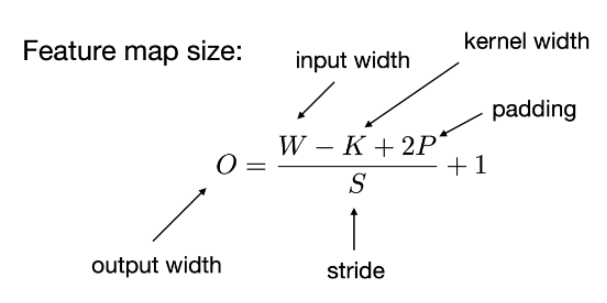

**B) Incorporar padding y stride distintos a los valores por defecto. Explicar en qué consisten estos conceptos**

**C) Dibujar la curva de la función costo en función de los pasos de entrenamiento. Variar el valor de la constante de aprendizaje (learning rate) y comentar si se observan diferencias en el comportamiento de la curva**

**D) Cambiar el parámetro _batch_size_ y explicar por qué varía la cantidad de pasos en el entrenamiento al modificarlo**

**E) Aumentar la cantidad de _epocs_. Observar cómo se comportan las curvas de aprendizaje**

**F) Agregar una capa convolucional, una capa de max pooling y una capa lineal de manera tal que la red siga funcionando. Explicar la elección de dimensiones para que la red sea funcional.**

**G) Reemplazar la red convolucional por un perceptrón multicapa. Variar la cantidad de capass y neuronaes y comprar los resultados**

> ## Ejercicio 2: Regularización


**A) Implementar _dropout_ y _penalidad L2_. Explicar ambos conceptos**

> ## Ejercicio 3: Validación


**A) Armar un set de validación separando parte del set de entrenamiento.**

**B) Implementar _early stopping_. Explicar para que sirve**